# An Exploration of Color in Katherine Mansfield's The Garden Party and Other Stories

## Benjamin Jenney

16 December 2020

Introduction to Computational Literary Analysis,

Department of English and Comparative Literature, Columbia University,

Instructor: Jonathan Reeve

In [ ]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.text import Text
import pandas as pd

In [2]:
#create preprocessing instances
stemmer = PorterStemmer()
lem = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

fulltext_gardenparty = open("../garden-party.md").read()
fulltext = fulltext_gardenparty.split('\n# ')

In [3]:
# list of titles operates as keys for the corpus dictionary
list_of_titles = [
    "At the Bay",
    "The Garden Party",
    "The Daughters of the Late Colonel",
    "Mr and Mrs Dove",
    "The Young Girl",
    "Life of Ma Parker",
    "Marriage à la Mode",
    "The Voyage",
    "Miss Brill",
    "Her First Ball",
    "The Singing Lesson",
    "The Stranger",
    "Bank Holiday",
    "An Ideal Family",
    "The Lady's Maid",   
    ]

In [4]:
def preprocess(corpus):
    '''Normalizes corpus, corpus is a dictionary'''
    
    titles = corpus.keys()
    
    for title in titles:
        corpus[title] = [w.lower() for w in nltk.word_tokenize(corpus[title]) if w.isalpha() and w.lower() not in stopwords]
        corpus[title] = [stemmer.stem(w) if not w == 'purple' else w for w in corpus[title]]
        corpus[title] = [lem.lemmatize(w) for w in corpus[title]]
    
    return corpus 

def buildCorpus(titles, delimiter):
    '''Build Corpus, Takes a list of titles 
    and a delimter, for splitting by chapter 
    or story, to create a dictionary'''
    
    text_gardenparty = fulltext_gardenparty[178:] # remove metadata
    
    stories = text_gardenparty.split(delimiter) # split by story
    
    for story in stories:
        story.replace('\n', ' ')
    
    corpus = {}
    
    for i, title in zip(range(0, len(titles)), titles):
        corpus.update({title : stories[i]})
    
    return preprocess(corpus)


In [5]:
def getAllHyponyms(synset, hyponyms = list()):
    '''Traverses a synset tree
    returns a set of the leaf nodes'''
    
    synset_hyponyms = synset.hyponyms()
    
    if synset_hyponyms:
        hyponyms += synset_hyponyms
        for hyponym in synset_hyponyms:
            getAllHyponyms(hyponym, hyponyms)
    
    return set(hyponyms)

def getSynsetsWords(synsets):
    '''extracts words from synset objects'''
    
    words = []
    
    for syn in synsets:
        for lem in syn.lemmas():
            words.append(lem.name().replace('_', " "))
    
    return words

def colorCounts(tokens, colors):
    '''Takes word tokens, and a list of colors and
    and returns a Counter object in descending order'''
    
    color_count = []
    
    for color in colors:
        for word in tokens:
            if color == word:
                color_count.append(word)
    
    c = Counter(color_count)
    
    # Order the Counter by largest color match counts
    c = {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)}
    return c

def getAllColorCounts(corpus, colors):

    titles = corpus.keys()
    
    corpus_color_counts = []
    
    for title in titles:
        corpus_color_counts.append(colorCounts(corpus[title], colors))
    
    return corpus_color_counts

def removeControversialColorWords(col):
    '''not all chromatic and achromatic colors 
    in WordNets are definitively color words
    for consistency I had to remove some
    Returns the difference of two sets'''
    
    contraversial_colors = ['rose', 'carnat', 'peach', 'pearl','coffee',
                           'straw', 'chocol', 'bleach', 'maiz', 'chalk', 
                            'canari', 'apricot','bone', 'cherri', 'wine', 
                            'copper', 'chestnut', 'carnation', 'chocolate',
                           'lemon', 'scarlet', 'amber', 'emerald', 'blond']
    
    return set(col) - set(contraversial_colors)

def getWordNetColors(wn):
    '''retrieve color words from WordNet
    and returns a list of colorwords
    with controversial colorwords removed'''
        
    colors_synsets = getAllHyponyms(wn.synsets('chromatic_color')[0])
    colors_synsets |= getAllHyponyms(wn.synsets('achromatic_color')[0])
    
    colors = getSynsetsWords(colors_synsets)
   
    colors[colors.index('fuschia')] = 'fuchsia' # word net spelling mistake?
    
    colors = [lem.lemmatize(w) for w in colors]
    
    return list(set(removeControversialColorWords(colors)))

def concordance(full_text, word, width=80, lines=25, islist=False):
    '''takes text, word, and options for running a simlpe
    concordance'''
    tobj = Text(full_text)
    return tobj.concordance(word, width=width, lines=lines)

In [6]:
wn_colors = getWordNetColors(wn)

corpus_colors = getAllColorCounts(buildCorpus(list_of_titles, '\n# '), wn_colors)

corpus = buildCorpus(list_of_titles, '\n# ')

In [7]:
def createColorDataFrame(list_of_titles, corpus_colors):
    '''creates a dataframe from each stories color serires'''
    
    df_dict_corpus_colors = {}
    
    i = 0
    
    for story_colors in corpus_colors:
        df_dict_corpus_colors[list_of_titles[i]] = pd.Series(story_colors, index = story_colors.keys())
        
        i += 1
    
    del i
    
    return df_dict_corpus_colors

def graphColorRatios(corpus, titles, color_counts):
    '''graphs match count ratios: numMatches/totalNumWords
    returns a list of color ratios'''
    
    color_ratios = []
    counts = []
    
    for color_count in color_counts:
        counts.append(sum(color_count.values()))
    
    for j, title in zip(range(0,len(list_of_titles)), list_of_titles):
            color_ratios.append(counts[j]/len(corpus[title]))
    
    pd.Series(color_ratios, index = list_of_titles).plot(kind='bar')
    
    return color_ratios

def graphGreatesColorWordRatios(ratios, list_of_titles, df_dict, corpus_colors):
    '''simply graphs color words matches and counts
    for stories with largest colorword ratios'''
    
    graph_colors = []
    t =[]
    dfs =[]
    
    for i, title in zip(range(0,len(list_of_titles)),list_of_titles):
            if ratios[i] > .015:
                graph_colors.append(corpus_colors[i])
                t.append(title)
    
    figure, axes = plt.subplots(1, 5)
    
    df_dict[t[0]].plot(kind='bar', figsize=(20,2), ax=axes[0], color=graph_colors[0].keys(), title=t[0])
    df_dict[t[1]].plot(kind='bar', ax=axes[1], color=graph_colors[1].keys(), title=t[1])
    df_dict[t[2]].plot(kind='bar', ax=axes[2], color=graph_colors[2].keys(), title=t[2])
    df_dict[t[3]].plot(kind='bar', ax=axes[3], color=graph_colors[3].keys(), title=t[3])
    df_dict[t[4]].plot(kind='bar', ax=axes[4], color=graph_colors[4].keys(), title=t[4])

## An Exploration of Color in Katherine Mansfield's The Garden Party and Other Stories  

Katherine Mansfield’s stories are often ambiguous, relying on the subconscious aspects of her characters, and the invocation of mood and the senses, to generate meaning in the reader. As such her stories are often discussed in terms of music or painting. In the preface of Julia van Gunsteren’s study *Katherine Mansfield and Literary Impressionism* Gunsteren argues, “… that, *if* we have to place Mansfield it will be in literary impressionism”(Gunsteren, 7) noting how many of Mansfield’s colorful descriptions lack linearity. And in a thesis published by the University of Auckland, entitled *Katherine Mansfield and Artistic Synaesthesia* researcher Miao Miao details Mansfield’s association with the Rhythmist movement which sought rhythmic natural harmony in art, and thus a breaking down of the delineations between arts various forms. Miao Miao details Mansfield's friendship with J.D. Fergusson, a fauvist painter, and illustrative editor for Rhythm magazine, the publication from which the Rhythmist movement got its name, and an epiphanic experience Mansfield had upon viewing a painting by Vincent Van Gogh. Miao, by looking at Mansfield's work and artistic evolution through the lens of fauvism, a movement which called for “a return to the organic… the intuitive and not analytical faculties of an artists mind, and an undifferentiated stage of innocent comprehension of seeing through a child’s eye” (Miao, 3) finds parallels with Mansfield’s own “innocent eye,” (Miao, 14) as well as her “shaking loose” from the boundaries of literary expression to create, what Mansfield termed as "word-paintings." (Miao, 14) Furthermore, Miao notes that Mansfield’s mature works “also demonstrate a musical concern [incorporating] rhythm in her narrative through choreographed movements, reiterated images and atmospheric descriptions.” (Miao, 1) In light of this I think it would be interesting to see how Mansfield incorporates color in her collection of late works *The Garden Party and Other Stories*, to achieve her inter-art aspirations.

To begin my analysis I set out to find particularly colorful works. Using WordNets lexical database I created a word color compendium based on the relational components for both chromatic and achromatic colors. I then normalized the text of each story, removing stop-words, stemming, and lemmatizing. I then divided the color match by the number of words in each respective story (sans stopwords) obtaining the color word ratios for each story in *The Garden Party and Other Stories.*


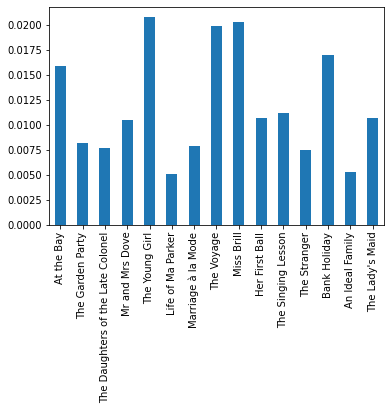

In [8]:
color_ratios = graphColorRatios(corpus, list_of_titles, corpus_colors)
df_dict = createColorDataFrame(list_of_titles, corpus_colors)    

Studying the graph above we can see that some stories have a much greater concentration of color-words than others, and that the most color-word dense work is “The Young Girl''. Which in its first ten paragraphs provides compelling examples of both fauvism and Mansfield's Innocent Eye. In fact the first example appears right in the very first sentence. 
> In her blue dress, with her cheeks lightly flushed, her blue, blue eyes, and her gold curls pinned up as though for the first time—pinned up to be out of the way for her flight—Mrs. Raddick’s daughter might have just dropped from this radiant heaven. 

Consider the repetition of the word blue in "her blue dress" and "her blue blue eyes." Mansfield's lack of adjective variance seems to insist on the fundamental aspect of blue simultaneously invoking its nounness (or thingness) as well as its adjective form. Although the lack of grammatical nuance can be seen as childlike it is not necessarily clear whether a more conventional description, using two non-redundant consecutive adjectives, such as "deep blue eyes" would carry more or less meaning.

Furthermore, blue, and gold, happen to be very thematic colors in *The Garden Party and Other Stories.* For instance, running a simple concordance on 'blue' shows that blue is most often used to describe either the sky, eyes, or clothing, and is often associated with youth. And gold is often a marker of some valuable material good, or of the sun's reflection in the sky. That the young girl in ‘The Young Girl’ is described with such a heavy blueness so early on, is perhaps a clue into Mansfield's sympathies, as the young girl turns out to not be the most likeable of characters, though a very sympathetic one.


The fact that ‘The Young Girl’ has the greatest color-word ratio is surprising as it doesn’t read as a particularly colorful work, unlike, say, ‘The Garden Party’, which is a story that largely takes place in, and makes a great point of, Laura’s idyllic garden, with Laura’s various descriptions of the natural beauty therein. “The Young Girl'', on the other hand, takes place in a casino carport, a diner, and in a car. However, ‘The Young Girl’ is not the only outlier.

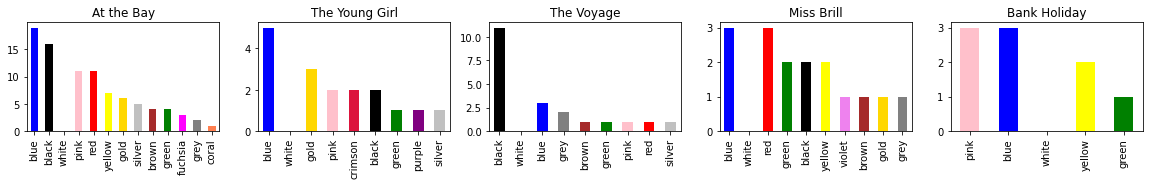

In [9]:
graphGreatesColorWordRatios(color_ratios, list_of_titles, df_dict, corpus_colors)

In the five graphs above we can see the number of occurrences of each color in each of the five stories that contain highest word-color-ratios, with the y-axes simply representing the number of times each color appears. Notably blue seems to be a favorite of Mansfield as well as black and white. That these colors appear in each of these stories, as well as just about every other story in *The Garden Party and Other Stories* evidences Mansfield's repetitive use of colors, and underscores the potential for an interstory rhythm of colors supporting Miao's claim of the rithmic qualities of Mansfield's later works. (Miao, 24)
 
"The Voyage" Stands out as being far and away the most black and white of story, which makes sense, since it is likely the most devastating story in *The Garden Party and Other Stories.* "The Voyage'' features a child protagonist who is being sent away to live with her grandparents, neither of whom she seems very fond of, in the very recent aftermath of what is likely the death of her mother (likely, because it is never stated outright who has died.) Similarly, we see young people coming to terms with mortality in 'The Daughters of the Late Colonel,' and 'The Garden Party'. In 'The Garden Party' Laura's encounter with death is foreshadowed by her wearing a "black hat trimmed with gold daisies, and a long black velvet ribbon" and in the ‘The Daughters of the Late Colonel’ we follow two young girls in the aftermath of their overbearing and patriarchal father. All three of these stories use black to create a serious, oppressive mood. Even ‘The Garden Party’ which starts off full of color, becomes drained of chromatism.

Arguably the two most colorful works, based on the ratio of color-words and variance in color-words, in *The Garden Party and Other Works* are ‘Miss Brill’ and ‘At the Bay.’ And since "At the Bay'' has the widest variety of color, it seems the best candidate for a word painting. It is also a longer piece, taking up about two thirds of the collection, and as such can give us interesting insights into the rhythmic, and word-painting qualities of Mansfield's work. 

Immediately in "At the Bay" we are awash with colors, in a strong display of what Gunsteren would likely call literary impressionism.
>Very early morning. The sun was not yet risen, and the whole of Crescent Bay was hidden under a white sea-mist. The big bush-covered hills at the back were smothered. You could not see where they ended and the paddocks and bungalows began... there were no white dunes covered with reddish grass beyond them; there was nothing to mark which was beach and where was the sea... The grass was blue. Big drops hung on the bushes and just did not fall; the silvery, fluffy toi-toi was limp on its long stalks, and all the marigolds and the pinks in the bungalow gardens were bowed to the earth with wetness. Drenched were the cold fuchsias, round pearls of dew lay on the flat nasturtium leaves. It looked as though the sea had beaten up softly in the darkness, as though one immense wave had come rippling, rippling—how far?

This sensational description, is full of natural color, where things seem to have no clear delineations: "The whole" of the bay is "hidden under a white sea-mist," The bushes "smother" the hills, where there is "nothing to mark" the divide between the beach and the sea which "had beaten up softly in the darkness... rippling how far?" The verbs "smother," and "beaten,", as well as the "big drops" that do not fall, reflect the impressionist painters desire to create contrast through action all in the instance of observation. And yet we also see some Fauvist qualities, the reddish grass, and the declarative "The grass was blue."


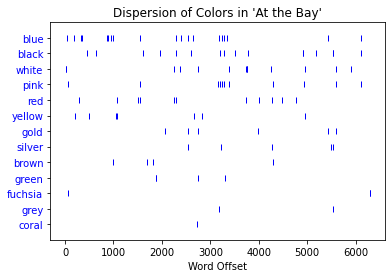

In [10]:
nltk.draw.dispersion_plot(corpus[list_of_titles[0]], 
                          list(corpus_colors[0].keys()), title="Dispersion of Colors in 'At the Bay'")

The impressionistic softness of the mist and the sea beating against the shore is continued in the atmosphere of the first few passages, as well as the word blue, which we can see in the lexical dispersion plot above, predominates the opening passages of 'At the Bay'. Blues, as in other stories in the collection, help create a dreamy and idyllic state, describing wide open skies, eyes, and, in this particular case, the smoke from a placid Shepherd’s pipe which "wreathed his head." Miao in a passage dedicated to the musical qualities of 'At the Bay' explains that it is not until the "participation of Mansfield's beloved children" do we see a movement away from the "languid sea."(Miao, 128) This is reflected in the dispersion plot, where adjacent mentions of red and pink between the 1000, and 2000 marker, coincide with Chapter four where we are first introduced to the children characters. Sure enough (roughly between the 2000 and 4000 marker) the color-words become more frequent and diverse. It seems that though Miao focuses more on the characters as providing "transposition" and rhythm(Miao, 126), color descriptions do as well. In fact if we look for the adjacent densities of blue and pink between the 3000 and 4000 markers, which coincide with the opening of Chapter VII, we find that the first few paragraphs mimic the impressionistic qualities of the opening passage I discussed earlier, but with a more frenetic energy, before a sharp dissipation in both natural and fauvist descriptions, as Kezia (one of the children in the story), in a conversation with her Grandma refuses to believe that her, or her grandma will ever die. After this pivotal moment in the story we see a distinct drop off in the diversity of color-words much like we did in 'The Garden Party' and other works with themes of death. Particularly we see a distinct absence of blue in the rest of the story. Interestingly enough, we do not see much of a return of color-words, until another pivotal and even terrifying scene, where we discover to our surprise, and very much too the surprise of the children, that one of the adults has black eyes! This reversal works to incredible effect, counterposing the frequent mentions of blue eyes, and working on our learned associations of both black and blue, within ‘At the Bay’, as well as in Mansfield's other works. The distinct lack of color leading up to this very staccato color moment, is analogous to dynamic changes in music. It is also one of the many examples of the innocent eye of Mansfield, as the scene takes place from the children's perspective, and feels inexplicably accurate in how children's imaginations generate fear, and the transience of that fear, when the children realize, that it's just one of the adults, come to pick them up.

In conclusion, I hope this brief study of color in Katherine Mansfield's *The Garden Party and Other Stories* inspires others to explore other colourful works. I also hope that by using quantitative techniques, I have provided further evidence for the inter-art qualities of Mansfield, and that by using color-word-ratios and dispersion plots, we can better understand the ways colors move inside literary works. Finally I hope by using NLP techniques to aid in a qualitative analysis of Mansfield's use of color, I have provided at least in some part a novel aspect to the studies of Mansfield's work.

## Citations

Miao, Miao. “Katherine Mansfield and Artistic Synaesthesia: Weaving Colour, Rhythm and Mood.” ResearchSpace Home, ResearchSpace@Auckland, 1 Jan. 1970,
researchspace.auckland.ac.nz/handle/2292/27183. 

Gunsteren, J. V. (1990). Katherine Mansfield and literary impressionism. Amsterdam: Rodopi.